In [121]:
import os, time, argparse, shutil, random
from collections import defaultdict, Counter
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from tensorboardX import SummaryWriter

from dataset import *
from model import CPM2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def train(args, epoch, model, criterion, optimizer, train_loader, writer, iters):
    
    model.train()
    
    for batch_idx, (img, target) in enumerate(train_loader):
        
        img, target = Variable(img.cuda()), Variable(target.cuda())
        img, target = img.type(torch.cuda.FloatTensor), target.type(torch.cuda.FloatTensor)
        
        #print('target', target.shape)
        #target = target.reshape(target.shape[0], -1,)
        outputs_stage1 = model(img, stage=1)
        #print('outputs_stage1', outputs_stage1.shape)
        optimizer.zero_grad()
        
        loss1 = criterion(outputs_stage1, target)
        input_stage2 = torch.cat([img, outputs_stage1], axis=1)
        #print('input_stage2', input_stage2.shape)
        outputs_stage2 = model(input_stage2, stage=2)
        #print('outputs_stage2', outputs_stage2.shape)
        loss2 = criterion(outputs_stage2, target)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0 and not batch_idx==0 :
            print('Train Epoch:{}/{} [{}/{} ({:.0f}%)]  Loss:{:.4f}'.format(
                epoch + 1, args.epochs,
                batch_idx * len(img), len(train_loader) * len(img),
                100.0 * batch_idx / len(train_loader), loss.item()
            ), end='\r')
            writer.add_scalar('loss', loss.item(), iters) # add to tensorboard
            iters += 1
            count=0
    return loss.item(), iters

def test(args, epoch, model, criterion, test_loader, writer, iters):
    model.eval()
    
    for batch_idx, (img, target) in enumerate(test_loader):
        
        img, target = Variable(img.cuda()), Variable(target.cuda())
        img, target = img.type(torch.cuda.FloatTensor), target.type(torch.cuda.FloatTensor)
        
        #target = target.reshape(target.shape[0], -1, )
        outputs_stage1 = model(img, stage=1)
        loss1 = criterion(outputs_stage1, target)
        input_stage2 = torch.cat([img, outputs_stage1], axis=1)
        outputs_stage2 = model(input_stage2, stage=2)
        loss2 = criterion(outputs_stage2, target)
        
        loss = loss1 + loss2
        
        if batch_idx % args.log_interval == 0 and not batch_idx==0 :
            print('Val Epoch:{}/{} [{}/{} ({:.0f}%)]  Val loss:{:.4f}'.format(
                epoch + 1, args.epochs,
                batch_idx * len(img), len(test_loader) * len(img),
                100.0 * batch_idx / len(test_loader), loss.item()
            ), end='\r')
            writer.add_scalar('valloss', loss.item(), iters) # add to tensorboard
    return loss.item()

def save_checkpoint(state, is_best, n_keypoints, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'checkpoints/model_best.kp%i.pth.tar' % n_keypoints)

def resume(args, ckpt,model):
    if os.path.isfile(ckpt):
        print('==> loading checkpoint {}'.format(ckpt))
        checkpoint = torch.load(ckpt)
        args.start_epoch = checkpoint['epoch']
        best_loss = checkpoint['loss']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer = checkpoint['optimizer']
        iters=checkpoint['iters']
        print("==> loaded checkpoint '{}' (epoch {})".format(args.resume, checkpoint['epoch']))
        return model,optimizer,args.start_epoch,best_loss,iters
    else:
        print("==> no checkpoint found at '{}'".format(args.resume))
    
def adjust_lr(args, optimizer, epoch, decay=20):
    """
        adjust the learning rate initial lr decayed 10 every 20 epoch
    """
    lr=args.lr*(0.1**(epoch//decay))
    for param in optimizer.param_groups:
        param['lr'] = lr

def get_model(modelname, n_keypoints, channels=1):
    model = CPM(n_keypoints, channels)
    return model

In [137]:
def get_args():
    args = {
        'batch_size': 8,
        'lr': 1e-3,
        'start_epoch': 0,
        'epochs': 20,
        'seed': 0,
        'log_interval': 10,
        'resume': None,
        'train_csv': 'data/training.csv',
        'test_csv': 'data/test.csv',
        'idlookup_table': 'data/IdLookupTable.csv',
    }
    return args

In [138]:
def get_dataset_indices(file, n_keypoints):
    df = pd.read_csv(file)
    notnan = df.apply(lambda x: np.sum(~x[:30].isnull()), axis=1)
    return notnan[notnan == n_keypoints*2].reset_index(drop=True).index

def get_dataloaders(n_keypoints, use_val=True):
    tsfm = transforms.Compose([transforms.ToTensor()])
    dataset = FacialKeyPointsDataset(csv_file=args.train_csv,
                                     n_keypoints=n_keypoints,
                                     size=(96,96),
                                     transform=tsfm)
    indices = get_dataset_indices(file=args.train_csv, n_keypoints=n_keypoints)
    kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
    
    if use_val:
        train_idx, val_idx = train_test_split(indices, test_size=0.15,
                                      shuffle=True, random_state=args.seed)
        train_sampler = SubsetRandomSampler(train_idx)
        val_samper = SubsetRandomSampler(val_idx)
        train_loader = DataLoader(dataset,
                              sampler=train_sampler,
                              batch_size=args.batch_size,
                              drop_last=True,
                              **kwargs)
        val_loader = DataLoader(dataset,
                            sampler=val_samper,
                            batch_size=args.batch_size*2,
                            drop_last=True,
                            **kwargs)
    else:
        train_sampler = SubsetRandomSampler(indices)
        train_loader = DataLoader(dataset,
                                  sampler=train_sampler,
                                  batch_size=args.batch_size,
                                  drop_last=True,
                                  **kwargs)
        val_loader = None
    
    return train_loader, val_loader
        
def main(n_keypoints, use_val=True):
    """
    Args:
        n_keypoints(int): number of keypoints (x,y) in dataset
        use_val(bool): False when using all train data for predictions,
                       otherwise, split train for testing
    """
    
    args.cuda = torch.cuda.is_available()
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    # SmoothL1Loss/Huber loss is less sensitive to outliers than MSELoss
    # absolute squared term < 1, use L1, else use L2
    criterion = nn.SmoothL1Loss()
    model = CPM2(n_keypoints=n_keypoints)
    optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9, 0.999))
    writer = SummaryWriter('logs/'+datetime.now().strftime('%B-%d'))
    best_loss = 1e+5
    best_loss_val = 1e+5
    iters = 0
    
    train_loader, val_loader = get_dataloaders(n_keypoints)
    
    assert model is not None
    if args.cuda: 
        model.cuda()
        #print(model)
    
    # resume training 
    if args.resume:
        model, optimizer, args.start_epoch, best_loss, iters = resume(args, args.resume, model)

    # train loop
    for epoch in range(args.start_epoch, args.epochs):
        adjust_lr(args, optimizer, epoch, decay=5)
        t1 = time.time()
        loss, iters = train(args, epoch, model,
                            criterion, optimizer,
                            train_loader, writer, iters)
        is_best = loss < best_loss
        best_loss = min(best_loss, loss)
        
        state = {
            'epoch':epoch,
            'state_dict':model.state_dict(),
            'optimizer':optimizer,
            'loss':best_loss,
            'iters': iters,
        }
        
        if use_val:
            loss_val = test(args, epoch, model, criterion,
                            val_loader, writer, iters)
            best_loss_val = min(best_loss_val, loss_val)
            state['loss_val'] = best_loss_val
            
        save_checkpoint(state, is_best, n_keypoints)
    writer.close()

In [139]:
args = dotdict(get_args())

In [140]:
main(n_keypoints=4, use_val=True)

Val Epoch:1/20 [160/704 (23%)]  Val loss:0.0053
Val Epoch:1/20 [320/704 (45%)]  Val loss:0.0052
Val Epoch:1/20 [480/704 (68%)]  Val loss:0.0047
Val Epoch:1/20 [640/704 (91%)]  Val loss:0.0049
Val Epoch:2/20 [160/704 (23%)]  Val loss:0.0026
Val Epoch:2/20 [320/704 (45%)]  Val loss:0.0030
Val Epoch:2/20 [480/704 (68%)]  Val loss:0.0021
Val Epoch:2/20 [640/704 (91%)]  Val loss:0.0022
Val Epoch:3/20 [160/704 (23%)]  Val loss:0.0018
Val Epoch:3/20 [320/704 (45%)]  Val loss:0.0018
Val Epoch:3/20 [480/704 (68%)]  Val loss:0.0015
Val Epoch:3/20 [640/704 (91%)]  Val loss:0.0015
Val Epoch:4/20 [160/704 (23%)]  Val loss:0.0019
Val Epoch:4/20 [320/704 (45%)]  Val loss:0.0011
Val Epoch:4/20 [480/704 (68%)]  Val loss:0.0015
Val Epoch:4/20 [640/704 (91%)]  Val loss:0.0013
Val Epoch:5/20 [160/704 (23%)]  Val loss:0.0012
Val Epoch:5/20 [320/704 (45%)]  Val loss:0.0015
Val Epoch:5/20 [480/704 (68%)]  Val loss:0.0015
Val Epoch:5/20 [640/704 (91%)]  Val loss:0.0015
Val Epoch:6/20 [160/704 (23%)]  Val loss

In [141]:
main(n_keypoints=15, use_val=False)

Traceback (most recent call last):
  File "/home/d/miniconda3/envs/nn/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/d/miniconda3/envs/nn/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/d/miniconda3/envs/nn/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/d/miniconda3/envs/nn/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


In [144]:
# trained on subset of data with 15 keypoints
model15 = CPM2(n_keypoints=15) # n=2284
model15.load_state_dict(torch.load('checkpoints/model_best.kp15.pth.tar')['state_dict'])
model15.eval()

# trained on full dataset but predicting 4 keypoints for all
model4 = CPM2(n_keypoints=4) #n=4755
model4.load_state_dict(torch.load('checkpoints/model_best.kp4.pth.tar')['state_dict'])
model4.eval()

CPM2(
  (block1a): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block1b): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block2): ConvBlock(
    (conv_block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [176]:
def show_heatmap(img, heatmap):
    plt.axis('off')
    plt.imshow(img, cmap='gray', alpha=0.5)
    plt.imshow(heatmap, alpha=0.5)

def get_img_and_output(model, df, idx):
    img = np.array(df.iloc[idx,1].split())
    img = img.astype(np.float32).reshape(96,96)
    #img /= 255.0
    img_input = np.expand_dims(img, axis=0)
    img_input = np.expand_dims(img_input, axis=0)
    img_input = torch.from_numpy(img_input)
    outputs_stage1 = model(img_input, stage=1)
    input_stage2 = torch.cat([img_input, outputs_stage1], axis=1)
    outputs_stage2 = model(input_stage2, stage=2)
    outputs_stage2 = outputs_stage2
    
    return img, outputs_stage2
    
def display_heatmap_eachkp(model, df, outfile):
    fig = plt.figure(figsize=(20, 6))
    fig.tight_layout()
    
    idx = random.randint(0, df.shape[0])
    img, heatmaps = get_img_and_output(model, df, idx)
    heatmaps = torch.squeeze(heatmaps, axis=0)
    n = len(heatmaps)
    for i in range(0, n):
        heatmap = heatmaps[i].detach().numpy()
        fig.add_subplot(2, (n + 1)//2, i + 1)
        show_heatmap(img, heatmap)
    fig.savefig(outfile)
    print(f'Saved to {outfile}')
        
def display_heatmap_combined(model, df, outfile):
    fig = plt.figure(figsize=(10, 10))
    fig.tight_layout()
    rows, columns = 3, 3
    for i in range(columns*rows):
        idx = random.randint(0, df.shape[0])
        img, heatmaps = get_img_and_output(model, df, idx)
        heatmaps = heatmaps.sum(axis=1)
        heatmaps = torch.squeeze(heatmaps, axis=0)
        heatmaps = heatmaps.detach().numpy()
        
        fig.add_subplot(rows, columns, i + 1)
        show_heatmap(img, heatmaps)

    if outfile:
        fig.savefig(outfile)
        print(f'Saved to {outfile}')

def display_heatmap_combined_one(model, df, idx, outfile):
    img, output = get_img_and_output(model, df, idx)
    show_heatmap(img, output)
    if outfile:
        plt.savefig(outfile)
        print(f'Saved to {outfile}')

Saved to samples/sample.15kp.eachheatmap.png


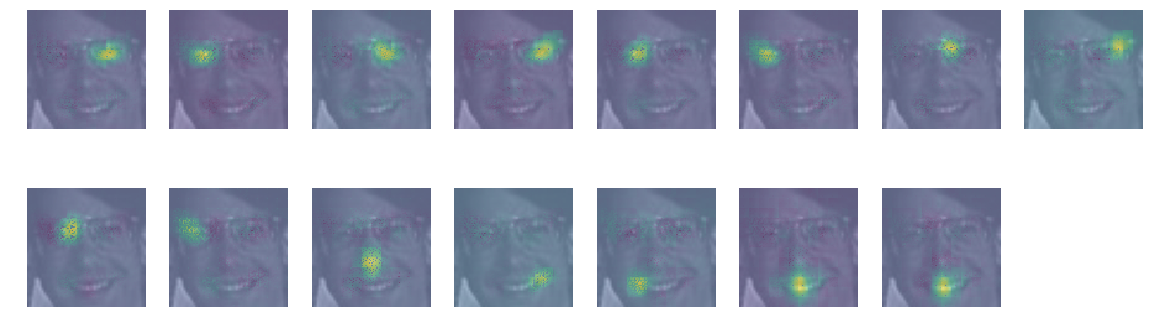

In [180]:
df = pd.read_csv('data/test.csv')
display_heatmap_eachkp(model15, df, 'samples/sample.15kp.eachheatmap.png')

Saved to samples/sample.15kp.combinedheatmap.png


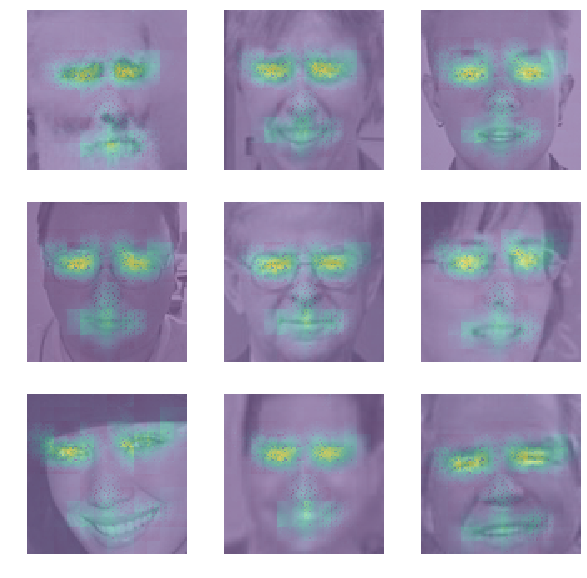

In [179]:
df = pd.read_csv('data/test.csv')
display_heatmap_combined(model15, df, 'samples/sample.15kp.combinedheatmap.png')

Saved to samples/sample1.png


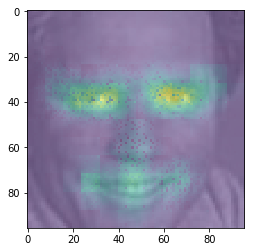

In [167]:
df = pd.read_csv('data/test.csv')
rand_idx = random.randint(0, df.shape[0])
display_heatmap_combined_one(model15, df, rand_idx, 'samples/sample1.png')

Saved to samples/sample2.png


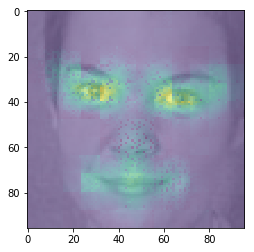

In [168]:
rand_idx = random.randint(0, df.shape[0])
display_heatmap_combined_one (model15, df, rand_idx, 'samples/sample2.png')

In [15]:
def create_submission():
    submission = []
    df = pd.read_csv(args.test_csv)
    df_train = pd.read_csv(args.train_csv)
    df_idlookup = pd.read_csv(args.idlookup_table)
    kp_cols15 = df_idlookup[df_idlookup['ImageId'] == 1]['FeatureName'] # sample with 15 keypoints
    kp_cols4 = df_idlookup[df_idlookup['ImageId'] == 1481]['FeatureName'] # sample with 4 keypoints
    total = df.shape[0]
    
    for id in df['ImageId']:
        print(id, total, end='\r')
        img = np.array(df[df['ImageId'] == id]['Image'].values[0].split())
        img = img.astype(np.float32).reshape(96,96)
        img /= 255.0
        img_input = np.expand_dims(img, axis=0)
        img_input = np.expand_dims(img_input, axis=0)

        keypoints_include = df_idlookup[df_idlookup['ImageId'] == id]['FeatureName']
        if len(keypoints_include) > 8:
            output = model15(torch.from_numpy(img_input))
        else:
            output = model4(torch.from_numpy(img_input))

        keypoints = output.detach().numpy()[0]
        keypoints = unnormalize_kp(df_train, keypoints)
        keypoints = keypoints.astype(np.int16)

        if len(keypoints_include) > 8:
            keypoints = keypoints[kp_cols15.isin(keypoints_include)]
        else:
            keypoints = keypoints[kp_cols4.isin(keypoints_include)]

        for i in range(len(keypoints)):
            submission.append(keypoints[i])

    write_submission(submission)

def write_submission(submission):
    df_submit = pd.DataFrame(submission)
    df_submit.columns = ['Location']
    df_submit['RowId'] = list(range(1,df_submit.shape[0]+1))
    df_submit = df_submit[['RowId', 'Location']]
    df_submit['Location'] = df_submit['Location'].apply(lambda x: x if x > 0 else 0)
    df_submit.to_csv('submissions/submission.csv', index=False)
    print('wrote to submission.csv', df_submit.shape)

In [16]:
create_submission()

wrote to submission.csv (27124, 2)317831783178317831783


In [17]:
!kaggle competitions submit -c facial-keypoints-detection -f submissions/submission.csv -m "test"

100%|█████████████████████████████████████████| 228k/228k [00:00<00:00, 387kB/s]
Successfully submitted to Facial Keypoints Detection